In [1]:
from datetime import datetime

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.saving import load_model

In [2]:
data_dir = 'data/sign_data'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'

train_df = pd.read_csv(f"{data_dir}/train_data.csv", header=None)
test_df = pd.read_csv(f"{data_dir}/test_data.csv", header=None)
train_df.columns = ["orig_path", "comp_path", "is_forg"]
test_df.columns = ["orig_path", "comp_path", "is_forg"]

metrics = ['accuracy', 'precision', 'recall', 'auc']

In [3]:
train_df.head()

,orig_path,comp_path,is_forg
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [4]:
filenames = pd.concat([train_df.orig_path, train_df.comp_path], axis=0).unique()
images = {}

_dir = train_dir

width, height = 224, 224
shape = (width, height)
for filename in filenames:
    image = cv2.imread(f'{_dir}/{filename}', cv2.IMREAD_GRAYSCALE)
    try:
        image = cv2.resize(image, shape)
    except Exception as e:
        print(f'ERROR: {_dir}/{filename}')
        raise e

    image = image.reshape(shape)
    image = np.asarray(image, dtype=np.float16)
    images[filename] = image

In [5]:
class DataLoader:
    def __init__(self, dataset: pd.DataFrame, batch_size: int, _dir: str, shape: (int, int)):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = _dir
        self.shape = shape

    def shuffle(self):
        return self.dataset.sample(frac=1)

    def generate(self):
        num_samples = len(self.dataset)
        while True:
            self.dataset = self.shuffle()
            for batch_begin in range(1, num_samples, self.batch_size):
                batch = self.dataset[batch_begin:batch_begin + self.batch_size]
                origs = np.array([images[i] for i in batch['orig_path']], dtype=np.float32)
                comps = np.array([images[i] for i in batch['comp_path']], dtype=np.float32)
                is_forgs = np.expand_dims(np.asarray(batch['is_forg']), axis=1)
                not_forgs = np.expand_dims(-(np.asarray(batch['is_forg']) - 1), axis=1)
                y = np.concatenate((not_forgs, is_forgs), axis=1)
                yield (origs, comps), y   

In [23]:
from tensorflow.keras import layers, losses, metrics, optimizers
from tensorflow.keras import Model
from tensorflow.keras import ops

x1 = layers.Input(shape=(width, height))
x2 = layers.Input(shape=(width, height))
# параллельная модель
inputs = layers.Input(shape=(width, height))
feature = layers.Conv1D(16, 3, activation='relu')(inputs)
feature = layers.MaxPooling1D(2)(feature)
feature = layers.Conv1D(32, 3, activation='relu')(feature)
feature = layers.MaxPooling1D(2)(feature)
feature = layers.Conv1D(64, 3, activation='relu')(feature)
feature = layers.MaxPooling1D(2)(feature)
feature = layers.Conv1D(128, 3, activation='relu')(feature)
feature = layers.MaxPooling1D(2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)

x1_net = feature_model(x1)
x2_net = feature_model(x2)
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv1D(128, 3, activation='relu')(net)
net = layers.MaxPooling1D(2)(net)
net = layers.Flatten()(net)
net = layers.Dense(512, activation='relu')(net)
net = layers.Dense(2, activation='sigmoid')(net)

classifier = Model(inputs=[x1, x2], outputs=net)
classifier.compile(loss=losses.BinaryCrossentropy(),
                   optimizer=optimizers.Adam(), metrics=['accuracy', Precision(), Recall(), AUC()])
classifier.summary()
classifier

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 224, 224)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 12, 128)   │     43,248 │ input_layer_9[0]… │
│ (Functional)        │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 12, 128)   │          0 │ functional_9[0][… │
│ (Subtract)          │                   │            │ functional_9[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 128)   │     49,280 │ subtract_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 5, 128)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 640)       │          0 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    328,192 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │      1,026 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 421,746 (1.61 MB)

 Trainable params: 421,746 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_11, built=True>

In [24]:
checkpoint_filepath = './checkpoints/best/signatures_binCE_e15.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_freq='epoch'
)

In [25]:
batch_size = 512
train_set, val_set = train_test_split(train_df, test_size=0.6)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, _dir=f'{data_dir}/train', shape=(width, height))
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, _dir=f'{data_dir}/train', shape=(width, height))


In [26]:
epochs = 15
day_month = datetime.now().strftime('%m_%d')
model_name = f'{day_month}_e{epochs}_bincrossentropy_resizing'

history = classifier.fit(
    train_loader.generate(),
    verbose=1,
    steps_per_epoch=int(len(train_set) / batch_size),
    epochs=epochs,
    validation_data=val_loader.generate(),
    validation_steps=int(len(val_set) / batch_size),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5322 - auc_2: 0.5622 - loss: 3.1554 - precision_2: 0.5568 - recall_2: 0.5494
Epoch 1: val_accuracy improved from -inf to 0.64757, saving model to ./checkpoints/best/signatures_binCE_e15.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 774ms/step - accuracy: 0.5347 - auc_2: 0.5639 - loss: 3.0926 - precision_2: 0.5585 - recall_2: 0.5500 - val_accuracy: 0.6476 - val_auc_2: 0.6976 - val_loss: 0.6712 - val_precision_2: 0.5939 - val_recall_2: 0.7982
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6798 - auc_2: 0.7279 - loss: 0.6304 - precision_2: 0.6292 - recall_2: 0.7625
Epoch 2: val_accuracy improved from 0.64757 to 0.75125, saving model to ./checkpoints/best/signatures_binCE_e15.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 708ms/step - accuracy: 0.6816 - auc_2: 0.7296 - loss: 0.6281 - precision_2: 0.6321 - recall_2: 0.7594 - val_accuracy: 0.7512 - val_auc_2: 0.8177 - val_loss: 0.5230 - val_precision_2: 0.7511 - val_recall_2: 

In [45]:
from tensorflow.keras.activations import softmax
def make_prediction(im1, im2):
    return np.argmax(softmax(classifier((np.expand_dims(im1, axis=0), np.expand_dims(im2, axis=0)))))

In [27]:
history.history.keys()

dict_keys(['accuracy', 'auc_2', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_precision_2', 'val_recall_2'])

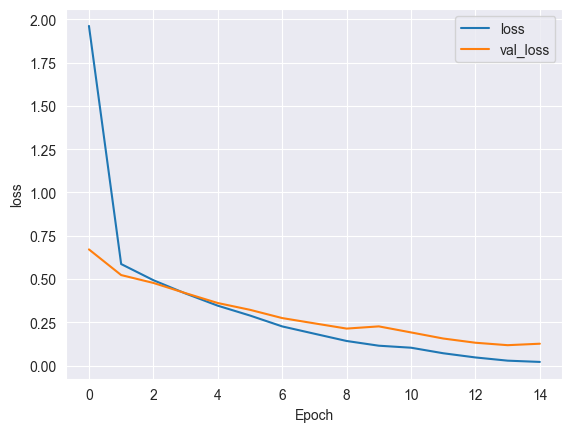

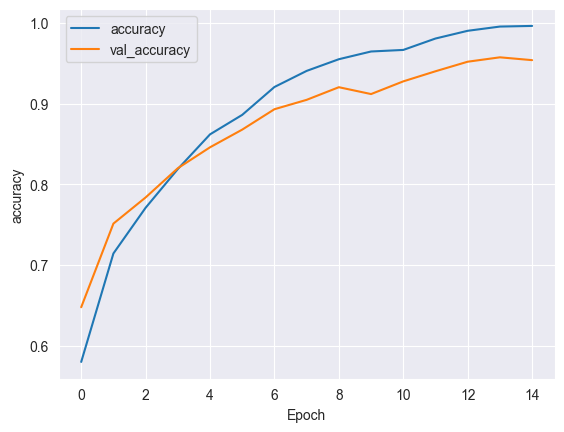

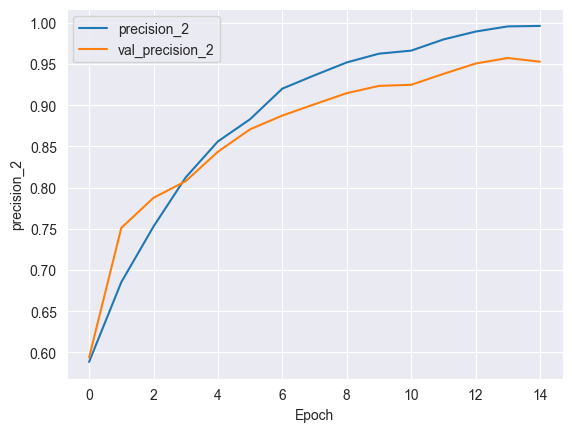

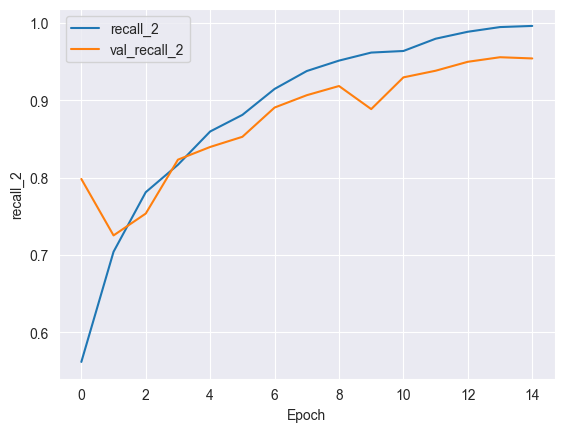

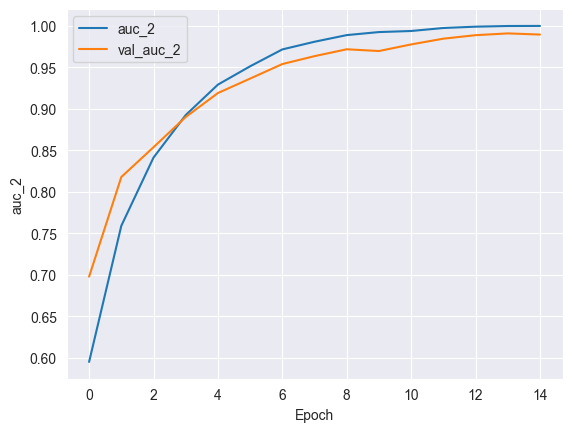

In [28]:
idx = 2
custom = [f'{i}_{idx}' for i in ['precision', 'recall', 'auc']]
metric_names = ['loss', 'accuracy'] + custom
for m in metric_names:
    val_m = f'val_{m}'
    plt.plot(history.epoch, history.history[m], history.history[val_m])
    plt.xlabel('Epoch')
    plt.ylabel(m)
    plt.legend([m, val_m])
    plt.savefig(f'./checkpoints/plots/{model_name}_{m}.png')
    plt.show()

In [29]:
def format_evals(evals, metric_names):
    return '\n'.join([f'{name} : {val}' for name, val in zip(metric_names, evals)])


test_loader = DataLoader(dataset=test_df, batch_size=batch_size, _dir=f'{data_dir}/test', shape=(width, height))
evals = classifier.evaluate(test_loader.generate(), steps=int(len(test_df) / batch_size))

print(format_evals(evals, metric_names))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.9723 - auc_2: 0.9944 - loss: 0.0852 - precision_2: 0.9718 - recall_2: 0.9730
loss : 0.084017314016819
accuracy : 0.9715909361839294
precision_2 : 0.9702549576759338
recall_2 : 0.9730113744735718
auc_2 : 0.9945523142814636


In [30]:
classifier.save(f'./checkpoints/{model_name}.keras')
with open(f'./checkpoints/{model_name}.testmetrics.txt', 'w', encoding='utf-8') as f:
    f.writelines(format_evals(evals, metric_names))
    f.flush()

In [73]:
for i in range(100):
    sample = test_df.iloc[i]
    im1 = images[sample.orig_path]
    im2 = images[sample.comp_path]
    is_forged = sample['is_forg']
    if is_forged != make_prediction(im1, im2):
        print(i)
        continue

23
63
79
87
95
98


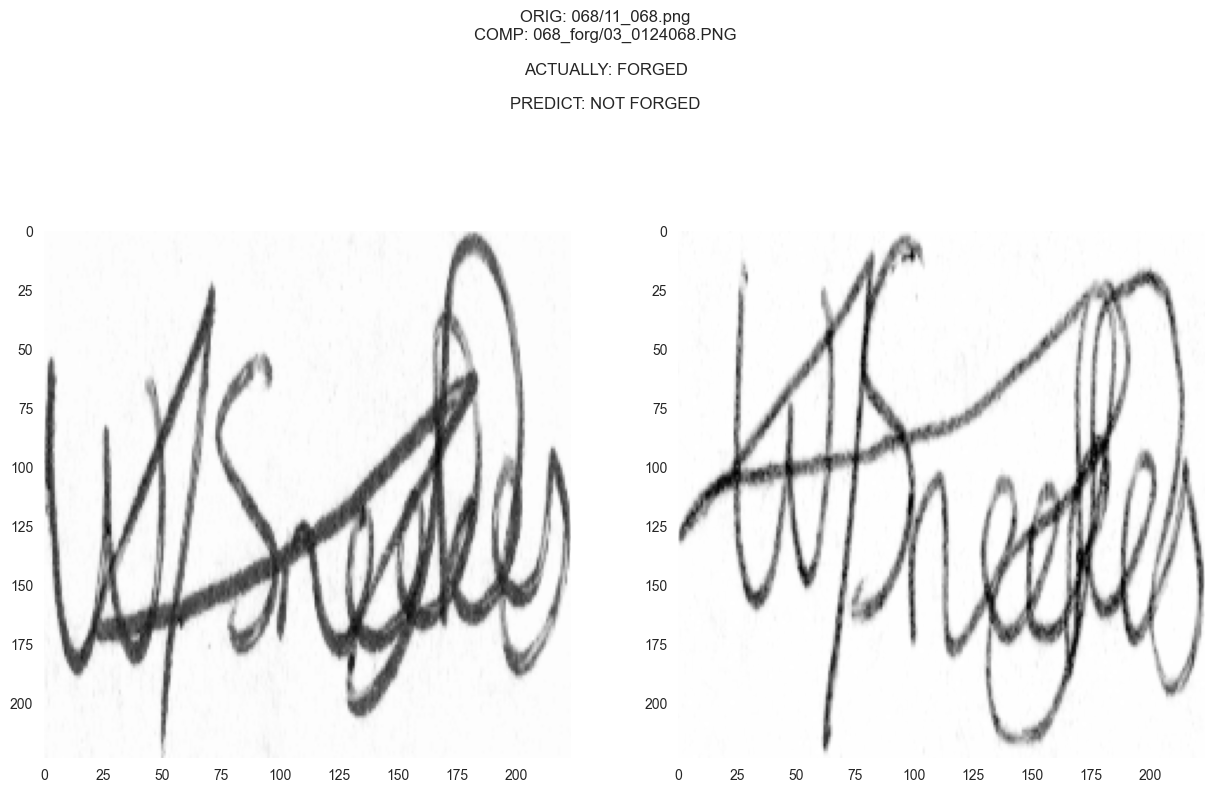

In [82]:

sample = test_df.iloc[23]
im1 = images[sample.orig_path]
im2 = images[sample.comp_path]
is_forged = sample['is_forg']

pred = make_prediction(im1, im2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(10)

title = ''
title += f'ORIG: {sample.orig_path}\n'
title += f'COMP: {sample.comp_path}\n\n'
title += f'ACTUALLY: {"FORGED" if is_forged else "NOT FORGED"}\n\n'
title += f'PREDICT: {"FORGED" if pred else "NOT FORGED"}'

fig.suptitle(title)
ax1.grid(False)
ax2.grid(False)
ax1.imshow(im1, cmap='gray')
ax2.imshow(im2, cmap='gray')
plt.show()